In [1]:
import os
path = os.path.abspath(os.getcwd())
print(path)
folder = os.path.split(path)[-1]
if folder == 'Subjects_Scripts':
    print('Subjects_Scripts')
    %run my_imports.py
elif folder == 'BREATHING_PROJECT_BIDS':
    print('BREATHING_PROJECT_BIDS')
    %run my_imports.py

C:\Users\bastien\Documents\Git\python_analysis_2\project\BREATHING_PROJECT\Subjects_Scripts
Subjects_Scripts


In [ ]:
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

In [ ]:
bids_root = r'D:\DataSet\MNE-test-data-bids'
datatype = 'eeg'
subject = 's25'
session = '01'
task = 'mi'
run_list = ['00','01','02','03','04','05']
raws_list = []
for run in run_list:
    bids_path = BIDSPath(subject=subject,session=session, task=task,run=run,
                     datatype=datatype, root=bids_root)
    raw = read_raw_bids(bids_path=bids_path, verbose=False)
    raws_list.append(raw)

In [ ]:
print(raws_list)
raws = mne.concatenate_raws(raws_list)
events,event_id = mne.events_from_annotations(raws)

In [3]:

montageFile = os.path.join(folderAnalysis,'locFile','montageANT64_inverse_v23.txt')
layoutFile  = os.path.join(folderAnalysis,'locFile','antneuro_64ch.lay')
chan_dict_file = os.path.join(folderAnalysis,'locfile','chan_dict_64ANT.txt')

f = open(chan_dict_file,'r')
chan_dict = eval(f.read())
     
cfg= {'spatial_filter': 'CAR',
'montage_file':montageFile,
'layout_file':layoutFile}

scale = dict(mag=1e-12, grad=4e-11, eeg=100, eog=150, ecg=500,
     emg=1e3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1e3, chpi=1e-4, whitened=1e2)

if 'AUX3' in raws.ch_names and 'AUX19' in raws.ch_names:
    print("1")
    resp_chan = "AUX3"
    mapping_channel_type = {'EOG':'eog','AUX3':'resp','AUX19':'ecg','M1':'emg','M2':'emg'}
elif 'AUX3' in raws.ch_names and 'AUX13' in raws.ch_names:
    print("2")
    resp_chan = "AUX3"
    mapping_channel_type = {'EOG':'eog','AUX3':'resp','AUX13':'ecg','M1':'emg','M2':'emg'}
elif 'AUX3' in raws.ch_names and 'AUX7' in raws.ch_names:
    print("3")
    resp_chan = "AUX3"
    mapping_channel_type = {'EOG':'eog','AUX3':'resp','AUX7':'ecg','M1':'emg','M2':'emg'}
elif 'AUX19' in raws.ch_names and 'AUX20' in raws.ch_names:
    print("4")
    resp_chan = "AUX19"
    if 'EOG' in raws.ch_names:
        mapping_channel_type = {'EOG':'eog','AUX19':'resp','AUX20':'ecg','M1':'emg','M2':'emg'}
    else:
        mapping_channel_type = {'AUX19':'resp','AUX20':'ecg','M1':'emg','M2':'emg'}
        
elif 'AUX3' in raws.ch_names:
    print("5")
    resp_chan = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX3':'resp','M1':'emg','M2':'emg'}
    
raws.set_channel_types(mapping_channel_type)

print('[Preprocessing] Preprocessed Data')

print('[Events Visualization] Checking events')
print(np.unique(events[:,2]))
print('[Events Visualization] Define dictionary for epoching')
    
listEventOfInterest = {'CUE_START_INHALE':43,
                 'CUE_START_EXHALE':44,
                 'CUE_STOP_INHALE':50,
                 'CUE_STOP_EXHALE':51}

# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raws.ch_names)
raws.rename_channels(new_names)

D:\results\Results_ANS\subjectFolderExperiment\s06\records\fif
[Load Data] Found 7 files
1
[Preprocessing] Preprocessed Data
[Events Visualization] Checking events
[10 20 30 40 43 44 50 51 55 70]
[Events Visualization] Define dictionary for epoching


In [ ]:
raws = set_montage_from_file_mne_v23(raws,cfg,kind='topomap')
raws.load_data()
# layout_from_raw = mne.channels.find_layout(raws.info, ch_type='eeg')
# layout_from_raw.plot()

# Independent Component Analysis

In [ ]:
from mne.preprocessing import ICA
method = 'fastica'

# Choose other parameters
n_components = 61  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 23
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

# Apply Temporal Filtering
picks_eeg = mne.pick_types(raws.info,eeg=True)
raws_filtered = raws.copy()
raws_filtered = raws_filtered.pick(picks_eeg)
raws_filtered.filter(l_freq =1,h_freq = 40)
print('[Preprocessing] Temporal Filtering applied on data (Step 1/3)')

listEventOfInterest = {'MI_START':40}
epochs  = mne.Epochs(raws_filtered, events, event_id=listEventOfInterest,
                         tmin=-8, tmax=6,baseline=None, preload = True)
ica.fit(epochs, picks='eeg', decim=decim)
print(ica)

In [ ]:
# ica.plot_components()  
ica.exclude.extend([0,1])
raws_ICA = ica.apply(raws_filtered)
print('[Preprocessing] Apply ICA on data (Step 2/3)')

In [ ]:
# Apply Spatial Filtering
picks_eeg = mne.pick_types(raws.info,eeg=True)
raws_preprocessed = raws_ICA.copy()
# raws_preprocessed = raws_preprocessed.pick(picks_eeg)
raws_ERDS  = apply_spatial_filter(raws_preprocessed,spatial_filer='CAR')
print('[Preprocessing] Spatial Filtering applied on data (Step 2/3)')

In [4]:
# raws_filtered = raws.copy()
# raws_filtered_ICA = raws_filtered.copy()
# # ica.apply(raws_filtered_ICA)
# print('[Preprocessing] ICA applied on data (Step 1/3)')

# # Apply Spatial Filtering
# picks_eeg = mne.pick_types(raws.info,eeg=True)
# raws_preprocessed = raws_filtered_ICA.copy()
# raws_preprocessed = raws_preprocessed.pick(picks_eeg)
# raws_preprocessed  = apply_spatial_filter(raws_preprocessed,spatial_filer='CAR')
# print('[Preprocessing] Spatial Filtering applied on data (Step 2/3)')

# # Apply Temporal Filtering
# raws_SCP = raws_preprocessed.copy()
# raws_ERDS = raws_preprocessed.copy()

# raws_SCP.filter(l_freq =0.1,h_freq = 3)
# raws_ERDS.filter(l_freq =1,h_freq = 40)
# print('[Preprocessing] Temporal Filtering applied on data (Step 3/3)')

[Preprocessing] ICA applied on data (Step 1/3)
[Preprocessing] Spatial Filtering applied on data (Step 2/3)
[Preprocessing] Temporal Filtering applied on data (Step 3/3)


# ERDS Phase Coupling 

In [5]:
listEventOfInterest = {'HOLD':40,'MI_START':40,
                'MI_STOP':55}

# Amplitude
raw_filter = raws.copy()
picks_RESP = raw_filter.ch_names.index(resp_chan)
resp_data = np.squeeze(raw_filter.get_data(picks=picks_RESP))
sfreq = raw_filter.info['sfreq']
transient_change = mne.filter.filter_data(resp_data,sfreq=sfreq,l_freq=0.1,h_freq=10)
transient_change = np.reshape(transient_change, (-1, 1)).T 
info = mne.create_info(['AUX3filter'], raws.info['sfreq'], ['ecg'])
stim_raw = mne.io.RawArray(transient_change, info)
raw_filter.add_channels([stim_raw], force_update_info=True)

# Need to inverse that data because of ANTneuro
raw_filter._data = -1*raw_filter._data

epochs_amplitude_resp = mne.Epochs(raw_filter, events, event_id=listEventOfInterest,
                     tmin=-4, tmax=6,baseline=(None), preload = True)

# Phase
picks_resp=raw_filter.ch_names.index("AUX3filter")
raw_hilb = raw_filter.copy().pick(picks_resp)
raw_hilb.apply_hilbert([0])

raw_phase = raw_hilb.copy()
raw_phase.apply_function(np.angle,[0])

epochs_phase  = mne.Epochs(raw_phase, events, event_id=listEventOfInterest,
                         tmin=-8, tmax=6,baseline=None, preload = True)

print(epochs_phase)

<Epochs  |   120 events (all good), -8 - 6 sec, baseline off, ~13.2 MB, data loaded,
 'HOLD': 60
 'MI_START': 60
 'MI_STOP': 60>


In [6]:
channelsOfInterest = ['Fz',\
                      'FCz','FC1','FC2','FC3', 'FC4',\
                     'Cz','C1', 'C2','C3', 'C4',\
                      'CP1', 'CP2','CP3', 'CP4']

#channelsOfInterest = ['C3','CP3']

print(channelsOfInterest)
raws_preprocessed = raws.copy()
picks_bandpower = mne.pick_channels(raws_preprocessed.ch_names,channelsOfInterest)
raws_preprocessed = raws_preprocessed.pick(picks_bandpower)

iter_freqs = [
 ('Mu', 8, 12),
   ('Beta', 13, 30),
]
print(iter_freqs)

epoch_bandpower = dict()

for band_name,fmin,fmax in iter_freqs:
    print(band_name)
    raws_filterband = raws_preprocessed.copy()
    # bandpass filter
    raws_filterband.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
                   l_trans_bandwidth=1,  # make sure filter params are the same
                   h_trans_bandwidth=1)  # in each band and skip "auto" option.
    # epoch
    raws_hilbert = raws_filterband.copy()
    raws_hilbert.apply_hilbert(envelope=True)
    epochs_filterband = mne.Epochs(raws_hilbert, events, listEventOfInterest, tmin=-8, tmax=6,preload=True,baseline=None)
    #epochs_filterband.subtract_evoked()
    #epochs_filterband.apply_baseline(baseline=baseline) # TOREADD
    epoch_bandpower.update({band_name:epochs_filterband})
    epoch_bandpower
    del epochs_filterband
    del raws_filterband
    del raws_hilbert

print(epoch_bandpower)

Mu
Beta
{'Mu': <Epochs  |   120 events (all good), -8 - 6 sec, baseline off, ~98.5 MB, data loaded,
 'HOLD': 60
 'MI_START': 60
 'MI_STOP': 60>, 'Beta': <Epochs  |   120 events (all good), -8 - 6 sec, baseline off, ~98.5 MB, data loaded,
 'HOLD': 60
 'MI_START': 60
 'MI_STOP': 60>}


HOLD
MI_START
MI_STOP
HOLD
MI_START
MI_STOP


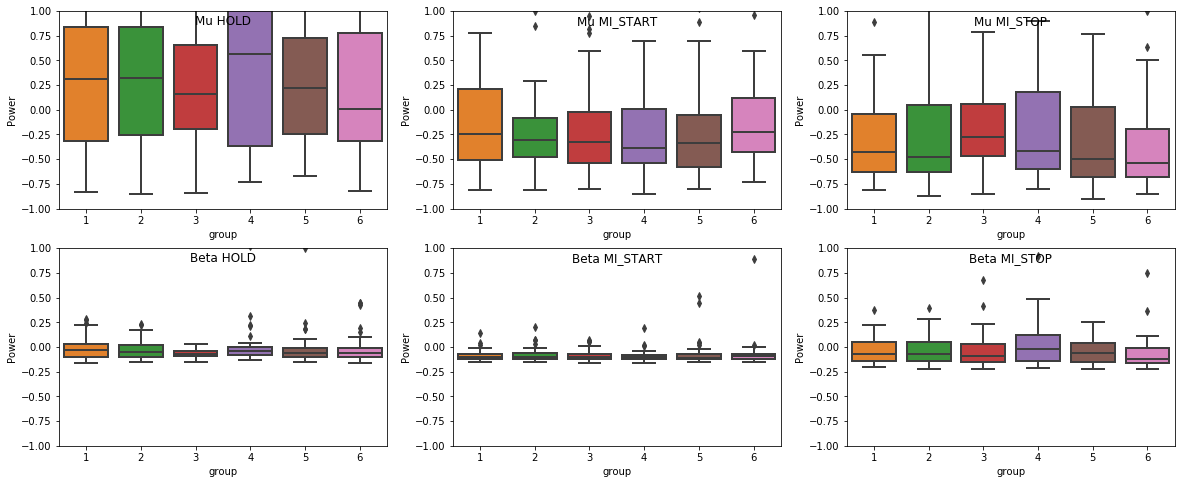

In [11]:
import seaborn as sns
import pandas as pd
from utils.utils_normalization import zscore_over_trials

baseline_event = {'HOLD':(-3,-1),'MI_START':(-3,-1),
                'MI_STOP':(-7,-5)}

fig = plt.figure(figsize=(20,8))
picks_respfiltered = raw_filter.ch_names.index("AUX3filter")
nbins = 7

bins = np.linspace(-np.pi, np.pi, nbins)

nBand = len(iter_freqs)
iplot = 0
df_events = dict()

timeInterval_event = {'HOLD':[-3,-1],'MI_START':[1,4],
                'MI_STOP':[1,3]}

for iBand,band_name in enumerate(epoch_bandpower):
    for iEvent,event_type in enumerate(listEventOfInterest):
        print(event_type)
        index_1 = np.where(epoch_bandpower[band_name].times == timeInterval_event[event_type][0])[0][0]
        index_2 = np.where(epoch_bandpower[band_name].times == timeInterval_event[event_type][1])[0][0]

        iplot +=1
        # phase respiration
        data_resp_event = np.squeeze(epochs_phase[event_type]).real
        data_resp_event = data_resp_event[:,index_1:index_2+1]
        ind = np.digitize(data_resp_event, bins)
 
        # baseline + bandpower
        data_mu = epoch_bandpower[band_name][event_type]._data
        data_mu = np.mean(data_mu, axis=1)
        #data_mu = zscore_over_trials(data_mu)
        data_mu = mne.baseline.rescale(data_mu, epoch_bandpower[band_name][event_type].times, 
                                        baseline=baseline_event[event_type])
        
        data_mu = data_mu[:,index_1:index_2+1]
        
        power_phase = []
        resp_phase = []
        df = pd.DataFrame()
        for iBin in range(nbins):
            a = data_mu * np.array(ind==iBin).astype(int)
            a[a==0] = np.nan
            power_phase.append(a)
        
        for iPhase,this_phase in enumerate(power_phase):
            pmu_trial = np.nanmean(this_phase,axis=1)
            a = pd.DataFrame({ 'group' : np.repeat(iPhase,len(pmu_trial)), 'Power': pmu_trial})
            df = df.append(a)
        
        
        event_band_type = band_name + "_" + event_type
        df_events.update({event_band_type:df})
        
        # Plotting
        axs=fig.add_subplot(230+iplot)
#         axs=fig.add_subplot(430+iplot)
        ax = sns.boxplot(x='group', y='Power', data=df,width=0.8,linewidth=2,showfliers = True)
        event_type = band_name + " " + event_type
        ax.set_title(event_type,y=0.9)
        axs.set_xlim([0.5,nbins-0.5])
        axs.set_ylim([-1,1])

# path = os.path.join(folderSubject,'ERDS_phase_coupling')
# event_type = 'bandpower_mu_beta_bands'
# saving_figure(event_type,path,fig)

# Saving Data


In [ ]:
saving_var('df_events_bandpower1330_ICA_nozscore',folderSubject,df_events)